In [121]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [7]:
data_dict = pd.read_excel('Tourism.xlsx',sheet_name='Data Dict')
tourism = pd.read_excel('Tourism.xlsx',sheet_name='Tourism')

In [8]:
data_dict.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Data,Variable,Discerption
1,NaN,Tourism,CustomerID,Unique customer ID
2,NaN,Tourism,ProdTaken,Product taken flag
3,NaN,Tourism,Age,Age of customer
4,NaN,Tourism,PreferredLoginDevice,Preferred login device of customer in last month


In [9]:
data_dict.drop('Unnamed: 0',axis=1,inplace=True)
data_dict.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Data,Variable,Discerption
1,Tourism,CustomerID,Unique customer ID
2,Tourism,ProdTaken,Product taken flag
3,Tourism,Age,Age of customer
4,Tourism,PreferredLoginDevice,Preferred login device of customer in last month


In [10]:
tourism.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [11]:
tourism.shape

(4888, 20)

In [12]:
tourism.isnull().sum()

CustomerID                   0
ProdTaken                    0
Age                        226
TypeofContact               25
CityTier                     0
DurationOfPitch            251
Occupation                   0
Gender                       0
NumberOfPersonVisited        0
NumberOfFollowups           45
ProductPitched               0
PreferredPropertyStar       26
MaritalStatus                0
NumberOfTrips              140
Passport                     0
PitchSatisfactionScore       0
OwnCar                       0
NumberOfChildrenVisited     66
Designation                  0
MonthlyIncome              233
dtype: int64

Total of 8 columns have some null values, maximum being for 'DurationOfPitch'. We will look into how to make adjustment/replacements for these null values.

In [13]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4888 non-null   int64  
 1   ProdTaken                4888 non-null   int64  
 2   Age                      4662 non-null   float64
 3   TypeofContact            4863 non-null   object 
 4   CityTier                 4888 non-null   int64  
 5   DurationOfPitch          4637 non-null   float64
 6   Occupation               4888 non-null   object 
 7   Gender                   4888 non-null   object 
 8   NumberOfPersonVisited    4888 non-null   int64  
 9   NumberOfFollowups        4843 non-null   float64
 10  ProductPitched           4888 non-null   object 
 11  PreferredPropertyStar    4862 non-null   float64
 12  MaritalStatus            4888 non-null   object 
 13  NumberOfTrips            4748 non-null   float64
 14  Passport                

There are 6 columns with data type as 'object'. We Will convert them into categorical variables for model building.

In [14]:
print(tourism.TypeofContact.value_counts())
print(tourism.Occupation.value_counts())
print(tourism.Gender.value_counts())
print(tourism.ProductPitched.value_counts())
print(tourism.MaritalStatus.value_counts())
print(tourism.Designation .value_counts())

Self Enquiry       3444
Company Invited    1419
Name: TypeofContact, dtype: int64
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64
Male       2916
Female     1817
Fe Male     155
Name: Gender, dtype: int64
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: MaritalStatus, dtype: int64
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: Designation, dtype: int64


Notice that we have 3 values in Gender column which seems to be a typo error. We will need to replace 'Fe Male' to 'Female' for model building.

In [15]:
tourism.describe()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4888.000000,4637.000000,4888.000000,4843.000000,4862.000000,4748.000000,4888.000000,4888.000000,4888.000000,4822.000000,4655.000000
mean,202443.500000,0.188216,37.622265,1.654255,15.490835,2.905074,3.708445,3.581037,3.236521,0.290917,3.078151,0.620295,1.187267,23619.853491
std,1411.188388,0.390925,9.316387,0.916583,8.519643,0.724891,1.002509,0.798009,1.849019,0.454232,1.365792,0.485363,0.857861,5380.698361
min,200000.000000,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,201221.750000,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,202443.500000,0.000000,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,203665.250000,0.000000,44.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,204887.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


* Most people are around age of 31 - 35. So we will replace the null values with mean value.
* Since "TypeofContact" has only two possible values, we will replace its null with previous value using ffill method.
* Max concentration of data for "DurationOfPitch" is between 5 and 20. So we will replace the null values by mean value.
* Similarly, we will replcae the null vlaue for "NumberOfFollowups" with it mean vlaue.
* For "PreferredPropertyStar" we will use the mean value to replace null.
* For "NumberOfTrips" we will use mean vlaue as the max concentration of data is between 1-4.
* For "NumberOfChildrenVisited" we will use mean value to replace null.
* For "MonthlyIncome" we can use mean value to replace the nulls.

We will do one hot encoding for these 6 columns later when getitng data ready for modelling.

# Perform an Exploratory Data Analysis on the data

In [11]:
#CustomerID is not useful in EDA and any modelling so we will drop this column.
tourism=tourism.drop('CustomerID',axis=1)

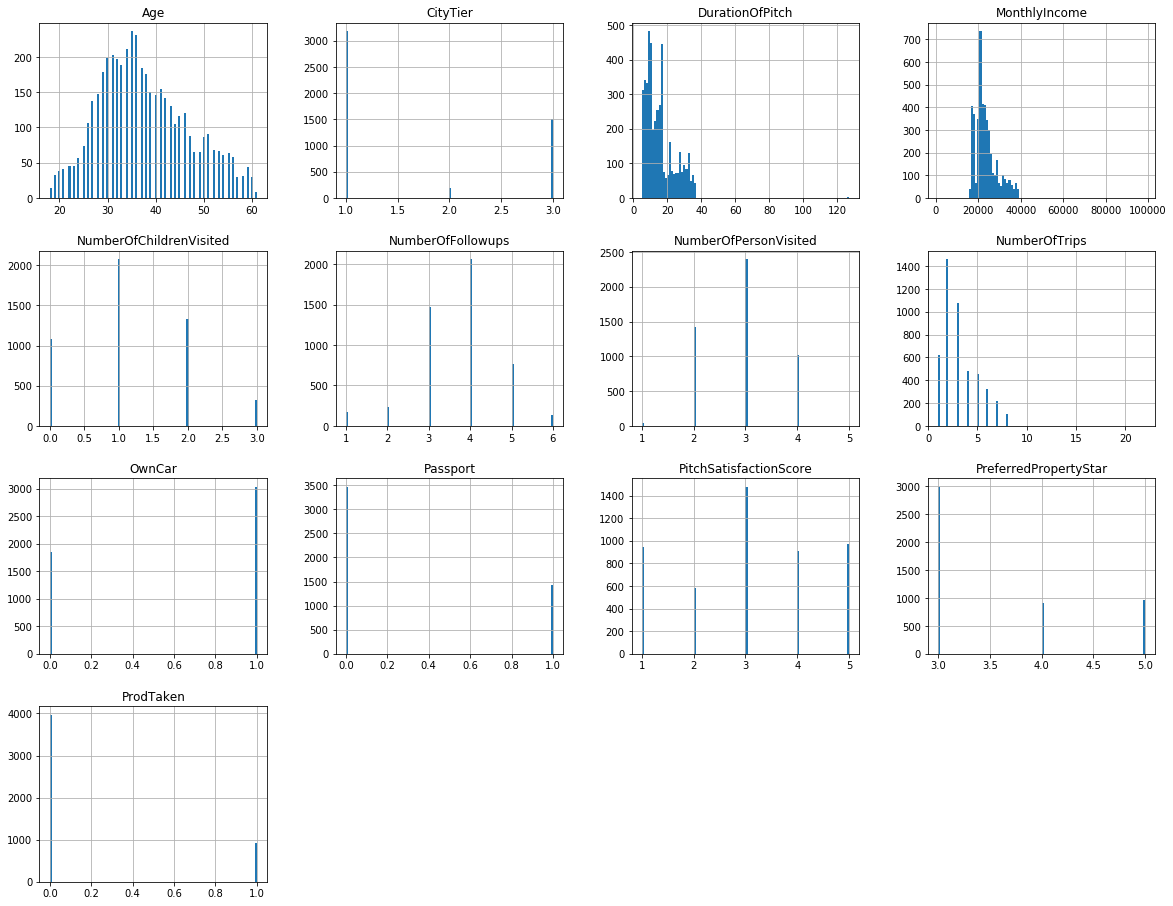

In [12]:
tourism.hist(bins=100, figsize=(20,20), layout=(5,4));

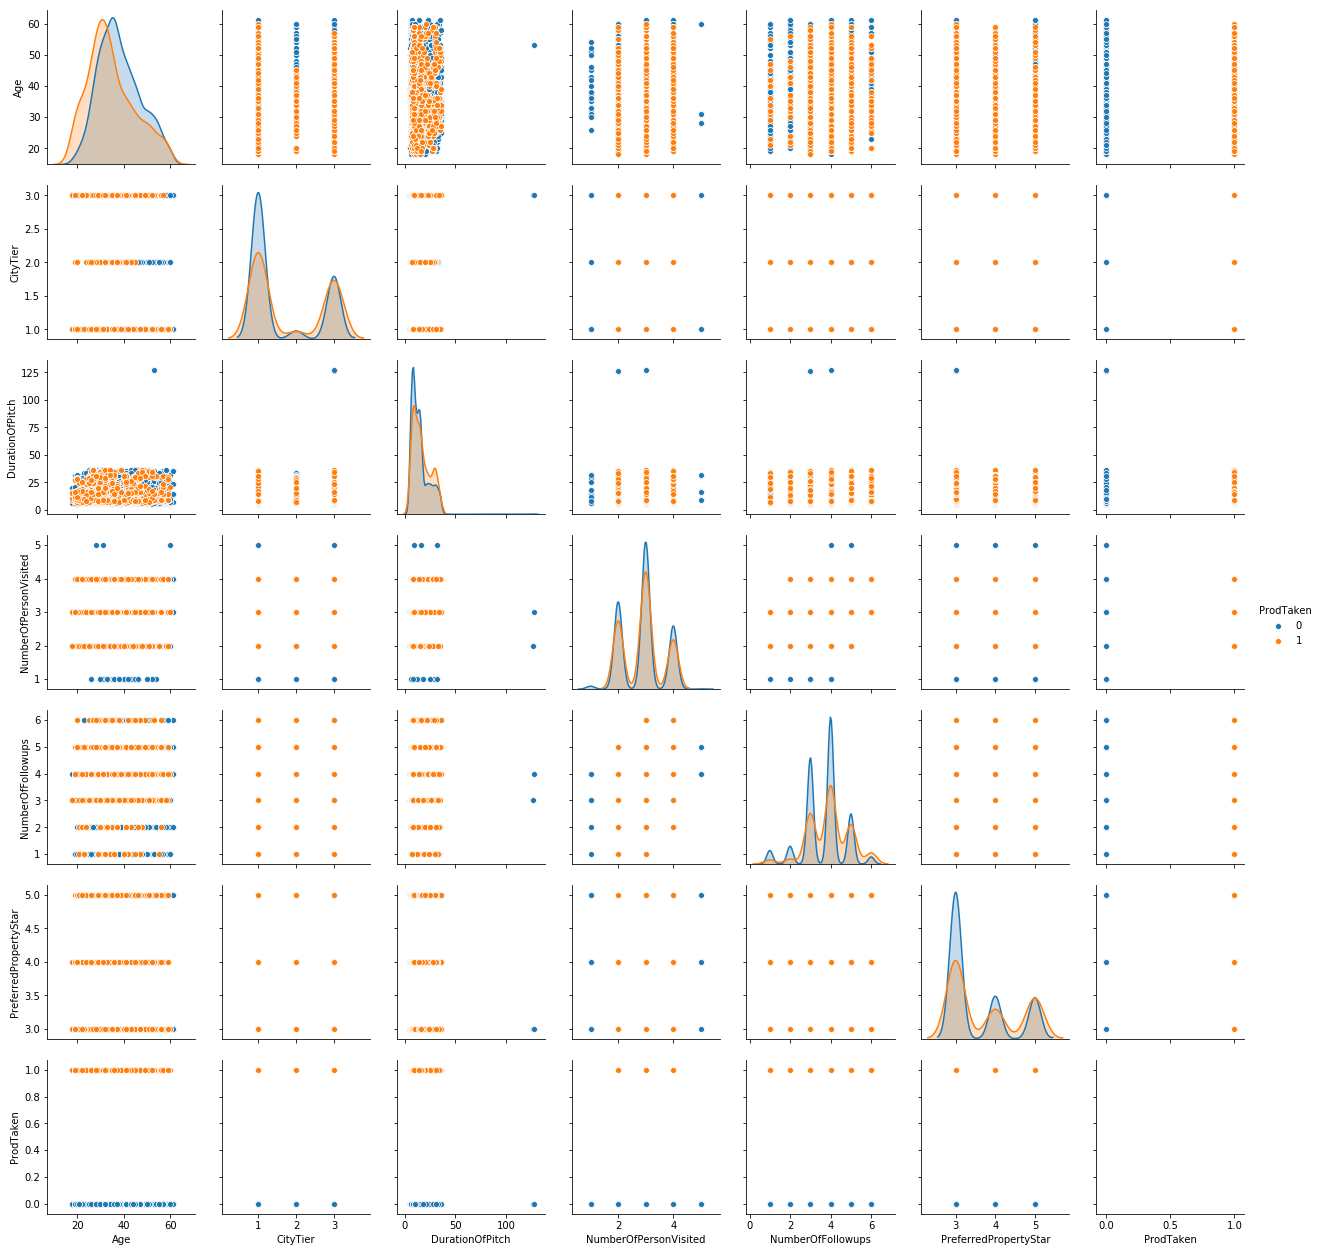

In [13]:
sns.pairplot(tourism[['Age', 'CityTier', 'DurationOfPitch','NumberOfPersonVisited','NumberOfFollowups','PreferredPropertyStar','ProdTaken']], hue='ProdTaken', diag_kind='kde')

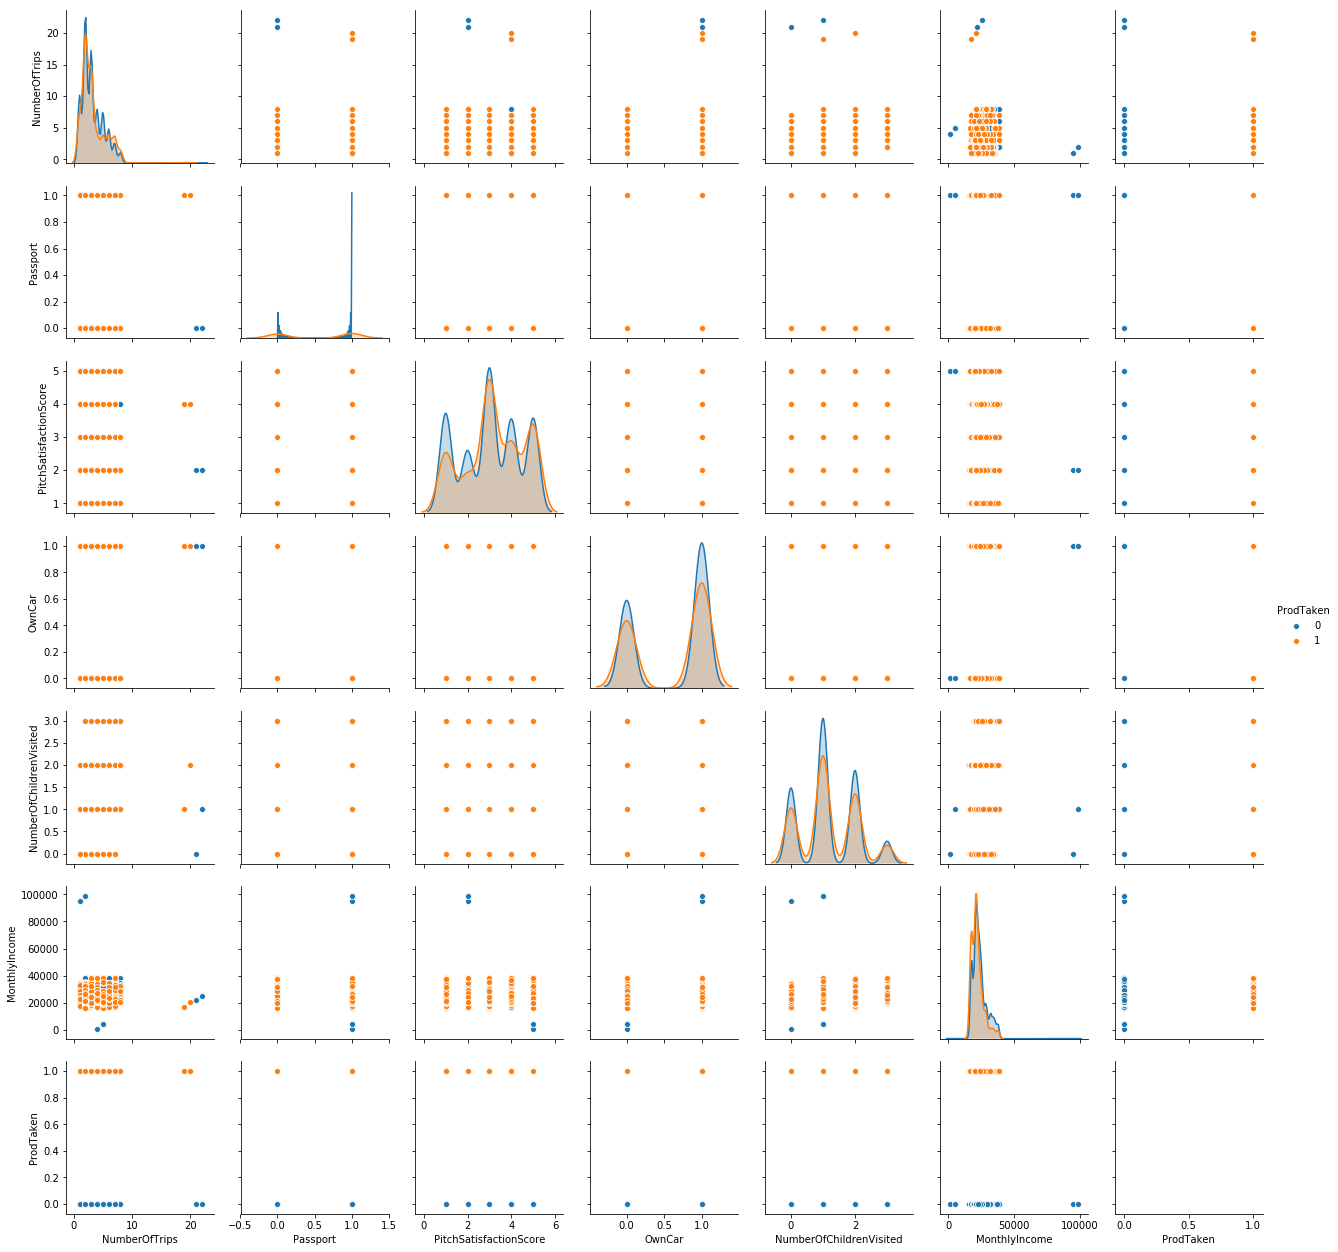

In [14]:
sns.pairplot(tourism[['NumberOfTrips','Passport','PitchSatisfactionScore','OwnCar','NumberOfChildrenVisited','MonthlyIncome','ProductPitched','ProdTaken']], hue='ProdTaken', diag_kind='kde')

**Observations**:
1. Age has almost no effect on whether customer has taken a product or not.
2. Max product were taken for either city tier 1 or 3. 
3. The chnace of taking a product is more if number of person visited with customer is 2,3 or 4.
4. Number of trips made by customer within a year is mostly less than 10.
5. Monthly income of large number of cusotmers who has taken a product is between 20k-40k

In [16]:
#Now lets do the replacement of null value as discussed above, befor plotting the histogram because NaN's are not handled well by the hist function
tourism['Age'].fillna(value=tourism['Age'].mean(), inplace=True)
tourism["TypeofContact"].fillna( method ='ffill', inplace = True)
tourism['DurationOfPitch'].fillna(value=tourism['DurationOfPitch'].mean(), inplace=True)
tourism['NumberOfFollowups'].fillna(value=tourism['NumberOfFollowups'].mean(), inplace=True)
tourism['PreferredPropertyStar'].fillna(value=tourism['PreferredPropertyStar'].mean(), inplace=True)
tourism['NumberOfTrips'].fillna(value=tourism['NumberOfTrips'].mean(), inplace=True)
tourism['NumberOfChildrenVisited'].fillna(value=tourism['NumberOfChildrenVisited'].mean(), inplace=True)
tourism['MonthlyIncome'].fillna(value=tourism['MonthlyIncome'].mean(), inplace=True)

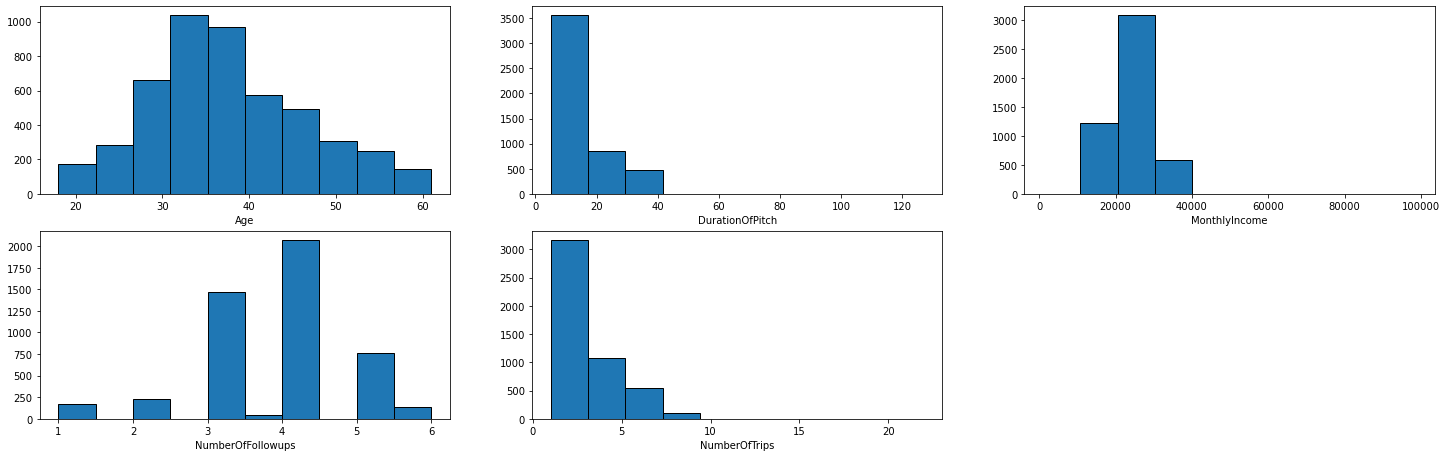

In [17]:
plt.figure(figsize= (25,20))
plt.subplot(5,3,1)
plt.hist(tourism.Age,edgecolor = 'black')
plt.xlabel('Age')

plt.subplot(5,3,2)
plt.hist(tourism.DurationOfPitch,edgecolor = 'black')
plt.xlabel('DurationOfPitch')

plt.subplot(5,3,3)
plt.hist(tourism.MonthlyIncome,edgecolor = 'black')
plt.xlabel('MonthlyIncome')

plt.subplot(5,3,4)
plt.hist(tourism.NumberOfFollowups,edgecolor = 'black')
plt.xlabel('NumberOfFollowups')

plt.subplot(5,3,5)
plt.hist(tourism.NumberOfTrips,edgecolor = 'black')
plt.xlabel('NumberOfTrips')

plt.show()

**Observations**:
1. DurationOfPitch, MonthlyIncome and NumberOfTrips are highly skewed dataset.
2. Age and NumberOfFollowups data set are not skewed rather evenly  distributed with some concentration.

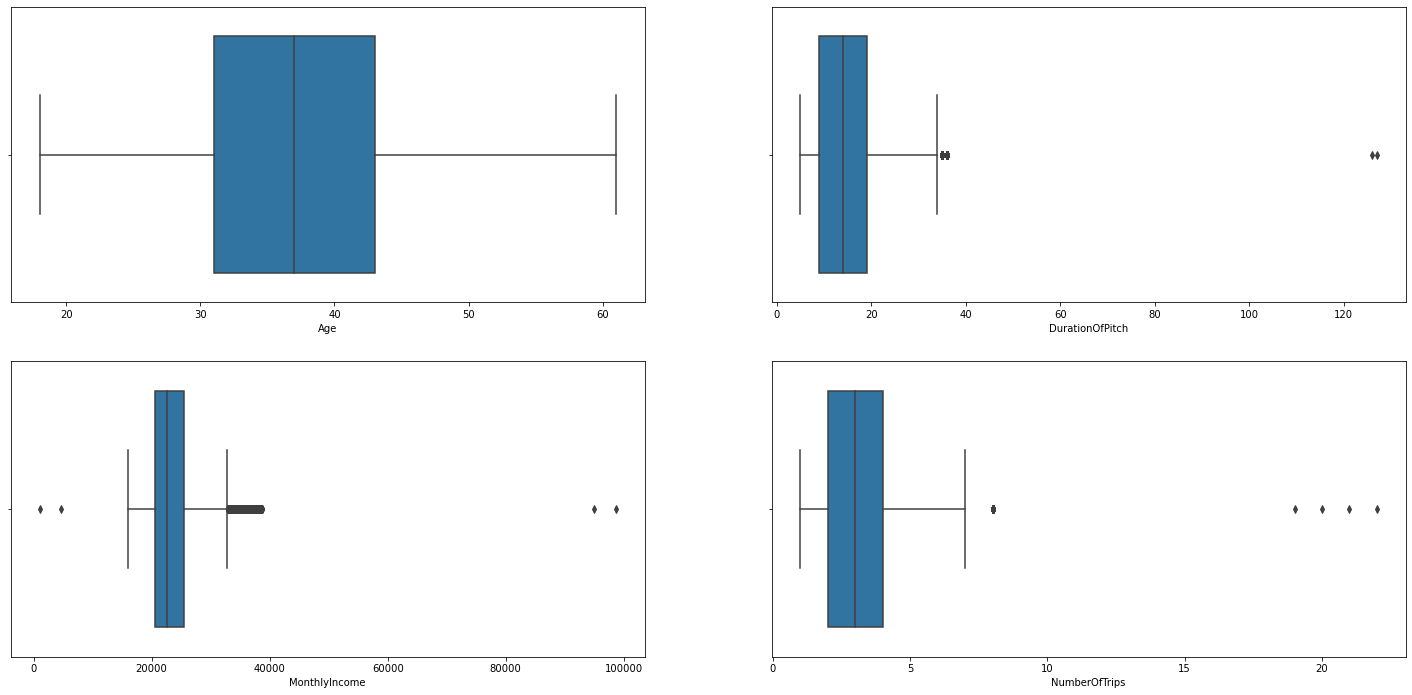

In [18]:
plt.figure(figsize= (25,25))
plt.subplot(4,2,1)
sns.boxplot(x= tourism.Age)

plt.subplot(4,2,2)
sns.boxplot(x= tourism.DurationOfPitch)

plt.subplot(4,2,3)
sns.boxplot(x= tourism.MonthlyIncome)

plt.subplot(4,2,4)
sns.boxplot(x= tourism.NumberOfTrips)

plt.show()

**Observations**:
1. Duration of pitch is less than 20 for most of time.
2. The monthly income for most of the customer is between 20K-25K - This is different from the observation above in pair plot.
3. Number of trips is less than 5 for most of the customers.

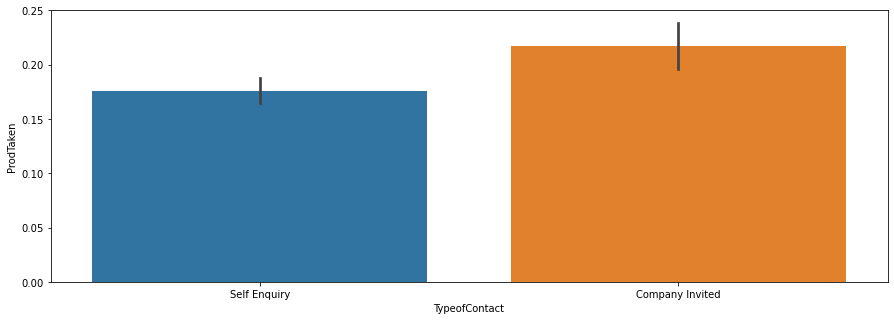

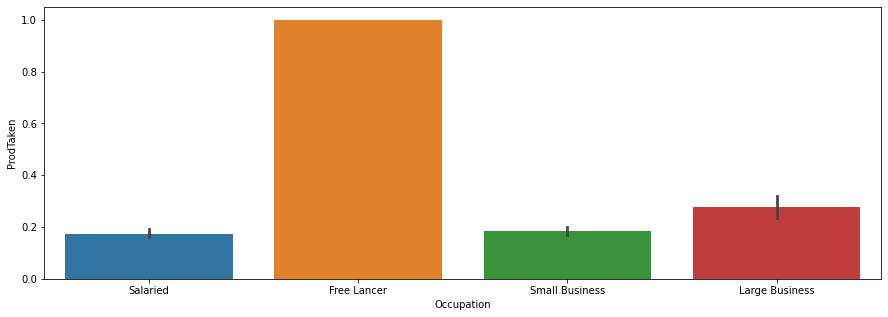

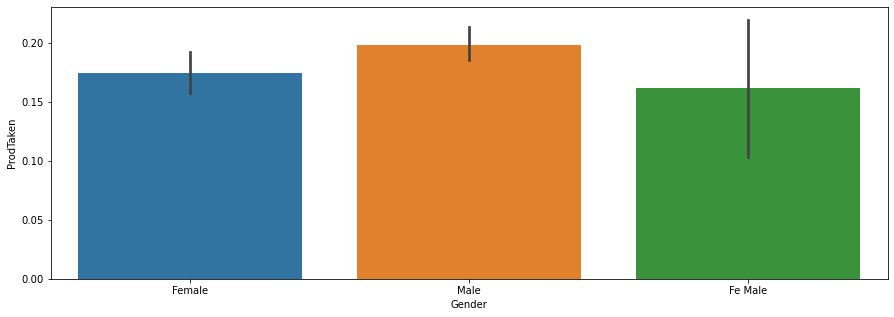

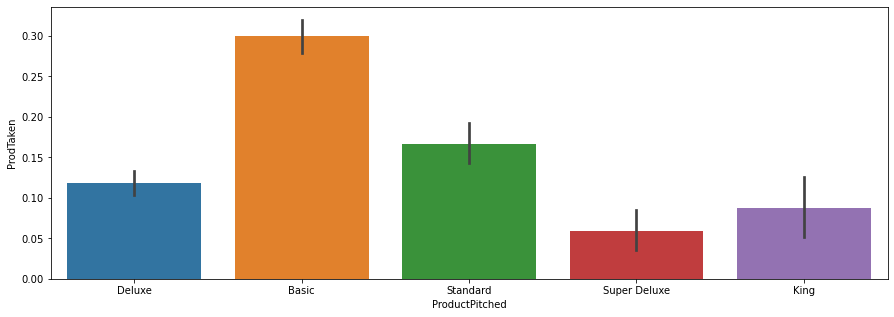

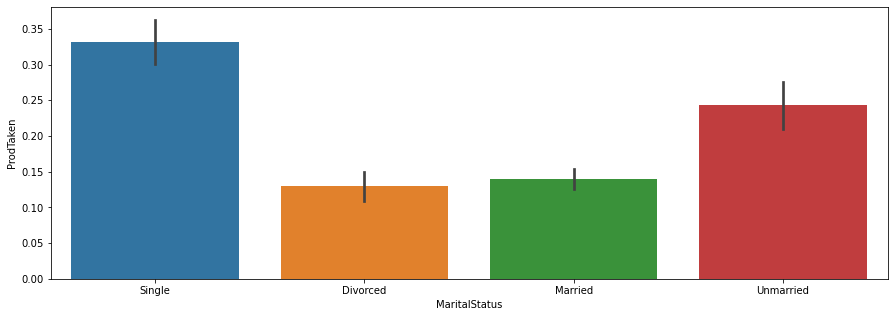

In [19]:
plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='TypeofContact', y='ProdTaken', data=tourism)

plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='Occupation', y='ProdTaken', data=tourism)

plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='Gender', y='ProdTaken', data=tourism)

plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='ProductPitched', y='ProdTaken', data=tourism)

plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='MaritalStatus', y='ProdTaken', data=tourism)


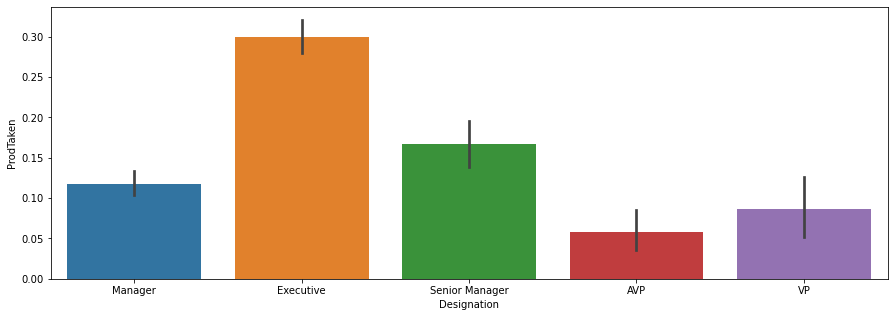

In [20]:
#This is written seperately because if i combine it with above code the resultant graphs are shown with the scroll bar.
plt.figure(figsize=(15,5)) 
plot = sns.barplot(x='Designation', y='ProdTaken', data=tourism)

**Observations**:
1. If the type of contact is "Company Invited" the there is little higher chance for product to be taken.
2. The chance of product taken by male customers is little higher than female customers.
3. The highest number of product taken was from basic categoty of product pitched.
4. Single and unmarried person are most likely to take a product.
5. Executive rank people are most likely to take a product compared to other designations.

In [21]:
tourism[['Age','CityTier', 'DurationOfPitch', 'NumberOfPersonVisited', 'NumberOfFollowups','PreferredPropertyStar','NumberOfTrips','Passport','PitchSatisfactionScore','OwnCar','NumberOfChildrenVisited','MonthlyIncome','ProdTaken']].corr()

,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome,ProdTaken
Age,1.000000,-0.015344,-0.011280,0.011298,-0.002477,-0.010130,0.175526,0.032602,0.018055,0.047525,0.006617,0.456273,-0.143717
CityTier,-0.015344,1.000000,0.022020,-0.001671,0.023524,-0.009145,-0.029352,0.001793,-0.042160,0.003817,0.000668,0.050644,0.086852
DurationOfPitch,-0.011280,0.022020,1.000000,0.063310,0.009197,-0.006448,0.009470,0.032245,-0.002810,-0.001585,0.030349,-0.006004,0.076297
NumberOfPersonVisited,0.011298,-0.001671,0.063310,1.000000,0.326649,0.033749,0.192513,0.011177,-0.019581,0.010362,0.607215,0.189278,0.009627
NumberOfFollowups,-0.002477,0.023524,0.009197,0.326649,1.000000,-0.023957,0.137420,0.004951,0.004035,0.012057,0.283545,0.172591,0.111675
PreferredPropertyStar,-0.010130,-0.009145,-0.006448,0.033749,-0.023957,1.000000,0.011880,0.001038,-0.022635,0.015712,0.035378,0.013432,0.099265
NumberOfTrips,0.175526,-0.029352,0.009470,0.192513,0.137420,0.011880,1.000000,0.012769,-0.004307,-0.011666,0.164996,0.120758,0.018739
Passport,0.032602,0.001793,0.032245,0.011177,0.004951,0.001038,0.012769,1.000000,0.002926,-0.022330,0.020132,0.002488,0.260844
PitchSatisfactionScore,0.018055,-0.042160,-0.002810,-0.019581,0.004035,-0.022635,-0.004307,0.002926,1.000000,0.068850,0.000872,0.029701,0.051394
OwnCar,0.047525,0.003817,-0.001585,0.010362,0.012057,0.015712,-0.011666,-0.022330,0.068850,1.000000,0.026414,0.078304,-0.011508


**None of the varibales are highly corelated to one another, this means we will run the modles including all the varibales.**

# Data Pre-processing

In [29]:
#CustomerID is not useful in EDA and any modelling so we will drop this column.
tourism=tourism.drop('CustomerID',axis=1)

In [31]:
#replace 'Fe Male' to 'Female'
tourism.replace(to_replace = 'Fe Male', value ='Female',inplace=True)

In [32]:
#Lets convert object columns into categorical variables.
for col in tourism.columns: 
    if tourism[col].dtype == 'object': 
        tourism[col] = pd.Categorical(tourism[col])
tourism.head(5)

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome
0,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [33]:
print(tourism.TypeofContact.value_counts())
print(tourism.Occupation.value_counts())
print(tourism.Gender.value_counts())
print(tourism.ProductPitched.value_counts())
print(tourism.MaritalStatus.value_counts())
print(tourism.Designation .value_counts())

Self Enquiry       3462
Company Invited    1426
Name: TypeofContact, dtype: int64
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64
Male      2916
Female    1972
Name: Gender, dtype: int64
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: MaritalStatus, dtype: int64
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: Designation, dtype: int64


In [34]:
#Now lets do the replacement of null value as discussed above.
tourism['Age'].fillna(value=tourism['Age'].mean(), inplace=True)
tourism["TypeofContact"].fillna( method ='ffill', inplace = True)
tourism['DurationOfPitch'].fillna(value=tourism['DurationOfPitch'].mean(), inplace=True)
tourism['NumberOfFollowups'].fillna(value=tourism['NumberOfFollowups'].mean(), inplace=True)
tourism['PreferredPropertyStar'].fillna(value=tourism['PreferredPropertyStar'].mean(), inplace=True)
tourism['NumberOfTrips'].fillna(value=tourism['NumberOfTrips'].mean(), inplace=True)
tourism['NumberOfChildrenVisited'].fillna(value=tourism['NumberOfChildrenVisited'].mean(), inplace=True)
tourism['MonthlyIncome'].fillna(value=tourism['MonthlyIncome'].mean(), inplace=True)

In [35]:
# Transforming the categorical variables to numerical
new_tourism= pd.get_dummies(tourism, columns=['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation'])

In [36]:
new_tourism.head()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,...,ProductPitched_Super Deluxe,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Unmarried,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP
0,1,41.000000,3,6.0,3,3.0,3.0,1.0,1,2,...,0,0,0,1,0,0,0,1,0,0
1,0,49.000000,1,14.0,3,4.0,4.0,2.0,0,3,...,0,1,0,0,0,0,0,1,0,0
2,1,37.000000,1,8.0,3,4.0,3.0,7.0,1,3,...,0,0,0,1,0,0,1,0,0,0
3,0,33.000000,1,9.0,2,3.0,3.0,2.0,1,5,...,0,1,0,0,0,0,1,0,0,0
4,0,37.622265,1,8.0,2,3.0,4.0,1.0,0,5,...,0,1,0,0,0,0,1,0,0,0


In [37]:
new_tourism.columns

Index(['ProdTaken', 'Age', 'CityTier', 'DurationOfPitch',
       'NumberOfPersonVisited', 'NumberOfFollowups', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisited', 'MonthlyIncome',
       'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry',
       'Occupation_Free Lancer', 'Occupation_Large Business',
       'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female',
       'Gender_Male', 'ProductPitched_Basic', 'ProductPitched_Deluxe',
       'ProductPitched_King', 'ProductPitched_Standard',
       'ProductPitched_Super Deluxe', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Unmarried', 'Designation_AVP', 'Designation_Executive',
       'Designation_Manager', 'Designation_Senior Manager', 'Designation_VP'],
      dtype='object')

# Split the data into train and test sets

In [38]:
X = new_tourism.drop("ProdTaken" , axis=1)
y = new_tourism.pop("ProdTaken")

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

**Before building the model, let's create functions to calculate different metrics- Accuracy, Recall and Precision and plot the confusion matrix.**

In [40]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [42]:
#Function to print feature importance
def print_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = list(X.columns)

    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Model building - Bagging

**Bagging Classifier**

In [44]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [45]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.9935691318327974
Accuracy on test set :  0.9066121336059987
Recall on training set :  0.968944099378882
Recall on test set :  0.5905797101449275
Precision on training set :  0.9968051118210862
Precision on test set :  0.8716577540106952


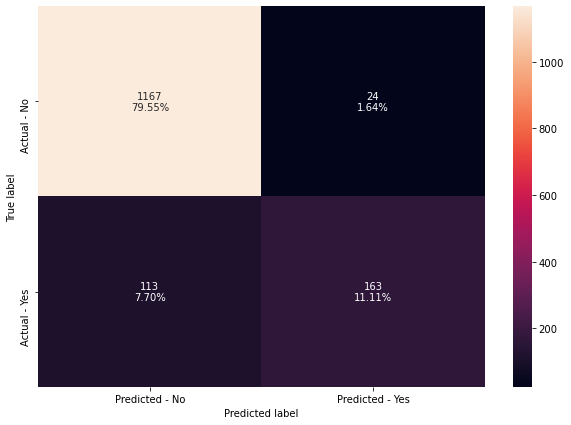

In [46]:
make_confusion_matrix(bagging_estimator,y_test)

**Random Forest Classifier**

In [47]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [48]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.912747102931152
Recall on training set :  1.0
Recall on test set :  0.572463768115942
Precision on training set :  1.0
Precision on test set :  0.9404761904761905


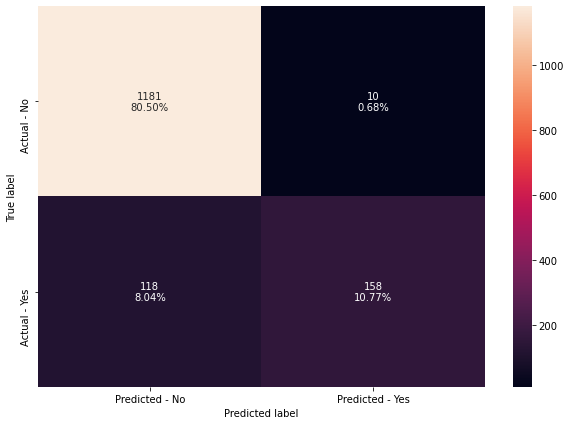

In [49]:
make_confusion_matrix(rf_estimator,y_test)

**Decision Tree Model**

In [50]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [51]:
dTree_estimator_score=get_metrics_score(dTree)

Accuracy on training set :  1.0
Accuracy on test set :  0.8895705521472392
Recall on training set :  1.0
Recall on test set :  0.6739130434782609
Precision on training set :  1.0
Precision on test set :  0.7209302325581395


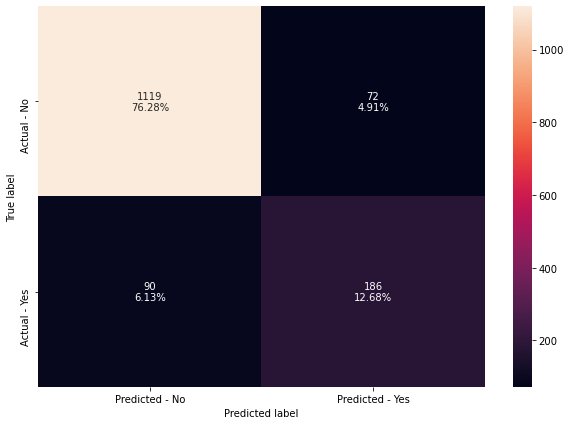

In [52]:
make_confusion_matrix(dTree,y_test)

**Observatios:**
1. All three models are overfitting the train data.
2. Decision tree is least performing in term of accuracy and recall. Bagging classifier and random forest has approximate similar performance in term of accuracy but bagging classifier is giving little better recall.

In [53]:
print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                    Imp
Age                            0.163261
DurationOfPitch                0.119055
MonthlyIncome                  0.094668
NumberOfTrips                  0.087228
Designation_Executive          0.070011
PitchSatisfactionScore         0.068928
Passport                       0.059067
CityTier                       0.051886
NumberOfFollowups              0.043534
MaritalStatus_Single           0.029110
PreferredPropertyStar          0.025362
Gender_Female                  0.021050
TypeofContact_Company Invited  0.017709
OwnCar                         0.016525
Occupation_Small Business      0.015849
Occupation_Large Business      0.015341
MaritalStatus_Divorced         0.014622
MaritalStatus_Unmarried        0.013363
TypeofContact_Self Enquiry     0.010830
MaritalStatus_Married          0.010569
NumberOfChildrenVisited        0.010146
Designation_Manager            0.008208
Occupation_Salaried            0.007869
NumberOfPersonVisited          0.007730


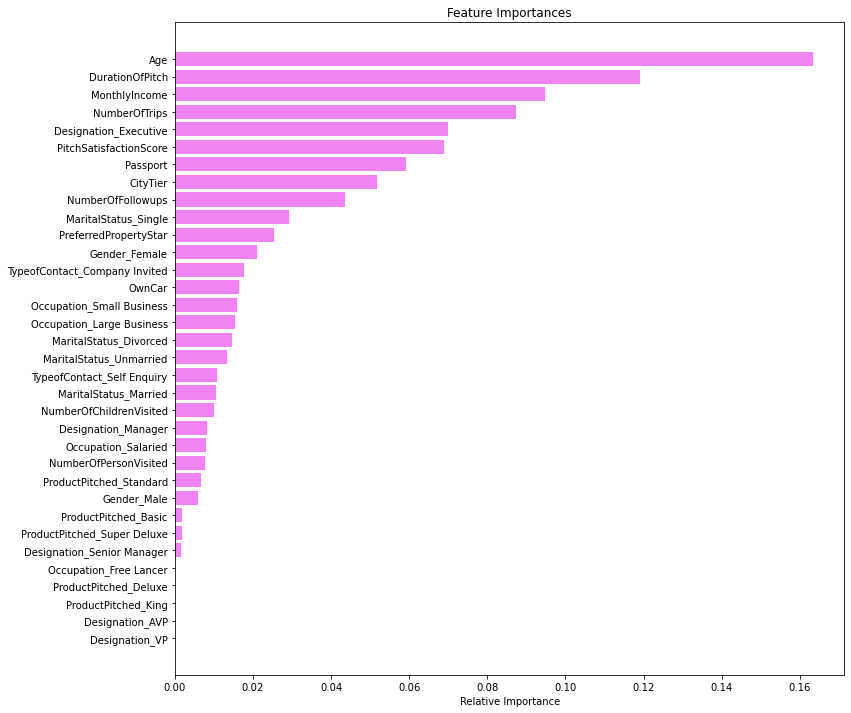

In [54]:
print_feature_importance(dTree)

According to the decision tree model, Age is the most important variable for predicting the customer default.
The tree above is very complex, such a tree often overfits.

#### Reducing overfitting

In [55]:
#Let's try Limiting the max_depth of tree to 5
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=5,random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

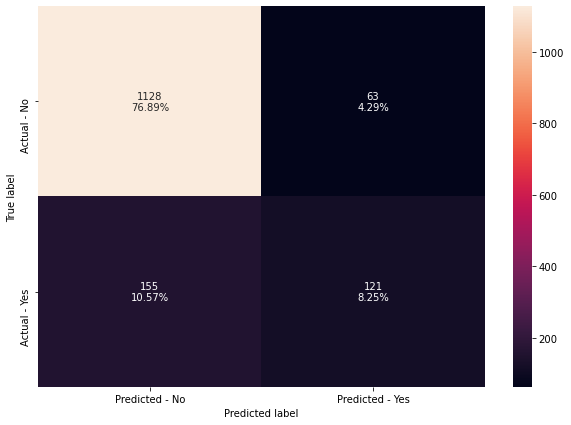

In [56]:
make_confusion_matrix(dTree1, y_test)

In [57]:
dTree1_estimator_score=get_metrics_score(dTree1)

Accuracy on training set :  0.8485822858813212
Accuracy on test set :  0.8513974096796183
Recall on training set :  0.4503105590062112
Recall on test set :  0.4384057971014493
Precision on training set :  0.6387665198237885
Precision on test set :  0.657608695652174


* Recall on training set has reduced from 1 to 0.45 but this is an improvement because now the model is not overfitting and recall on test data is also around 0.43. We have a generalized model.

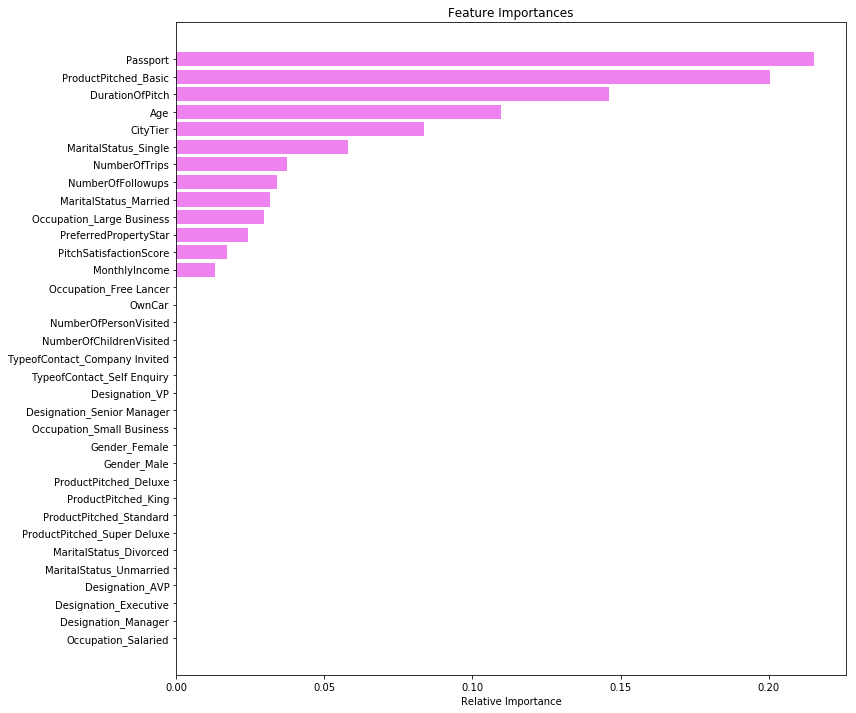

In [78]:
print_feature_importance(dTree1)

**Observations:**
1. We can see in important features of previous model, age was on top, but here importance of age variable is reduced and passport is on top.
2. We will go for pre pruning using grid search to fing the best values.

## Hyperparameter tuning for Decision tree, bagging classifier and Random Forest Classifier

#### Hyperparameter tuning of tree model

In [58]:
dTree_estimator = DecisionTreeClassifier(random_state=456789)

parameters = {'max_depth': [4,5,6,7], 
              'min_samples_leaf': [5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(dTree_estimator, parameters, scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

dTree_estimator = grid_obj.best_estimator_

dTree_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   30.7s finished


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3,
                       min_impurity_decrease=0.001, min_samples_leaf=5,
                       random_state=456789)

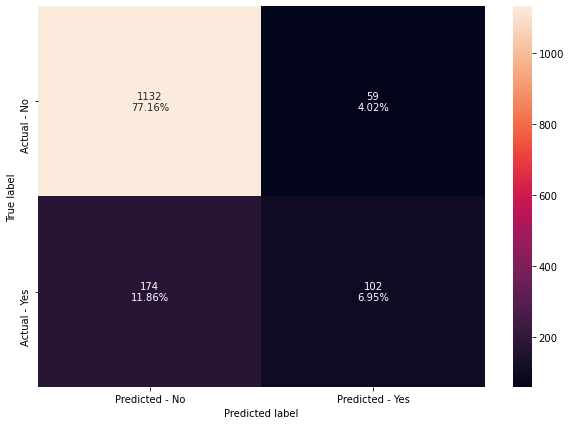

In [59]:
make_confusion_matrix(dTree_estimator,y_test)

In [60]:
estimator_score=get_metrics_score(dTree_estimator)

Accuracy on training set :  0.8213972522654195
Accuracy on test set :  0.8411724608043627
Recall on training set :  0.3416149068322981
Recall on test set :  0.3695652173913043
Precision on training set :  0.5405405405405406
Precision on test set :  0.6335403726708074


In [61]:
print (pd.DataFrame(dTree_estimator.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                    Imp
Passport                       0.518003
ProductPitched_Basic           0.481997
Age                            0.000000
MaritalStatus_Married          0.000000
ProductPitched_Deluxe          0.000000
ProductPitched_King            0.000000
ProductPitched_Standard        0.000000
ProductPitched_Super Deluxe    0.000000
MaritalStatus_Divorced         0.000000
MaritalStatus_Single           0.000000
Gender_Female                  0.000000
MaritalStatus_Unmarried        0.000000
Designation_AVP                0.000000
Designation_Executive          0.000000
Designation_Manager            0.000000
Designation_Senior Manager     0.000000
Gender_Male                    0.000000
Occupation_Small Business      0.000000
CityTier                       0.000000
Occupation_Salaried            0.000000
Occupation_Large Business      0.000000
Occupation_Free Lancer         0.000000
TypeofContact_Self Enquiry     0.000000
TypeofContact_Company Invited  0.000000


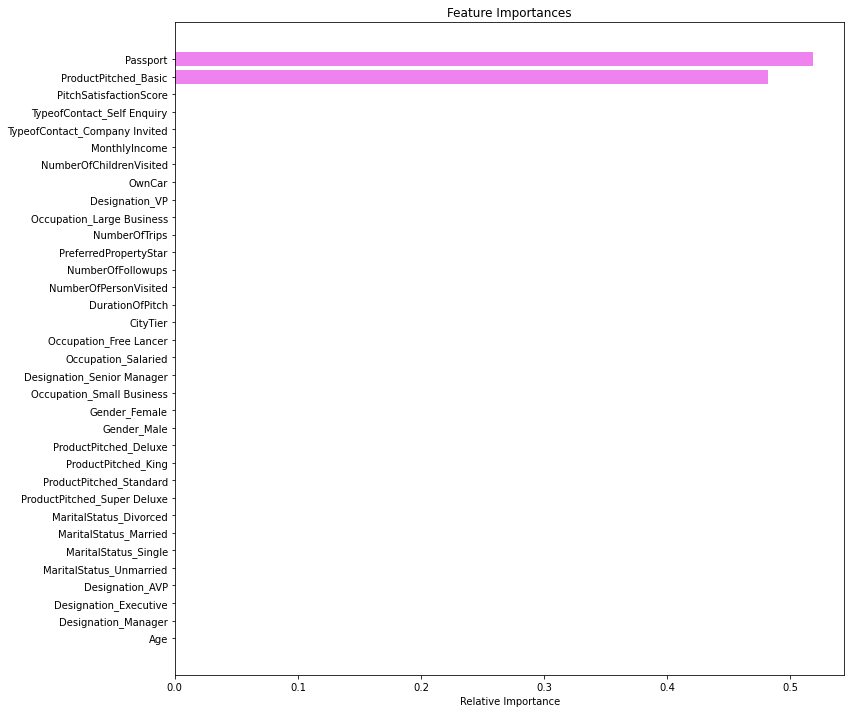

In [62]:
print_feature_importance(dTree_estimator)

**Hyperparameter tuning for bagging classifier**

In [63]:
bagging_estimator_tuned = BaggingClassifier(random_state=1)

parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)


grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

bagging_estimator_tuned = grid_obj.best_estimator_

bagging_estimator_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   36.0s finished


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=50,
                  random_state=1)

In [65]:
bagging_estimator_tuned_score=get_metrics_score(bagging_estimator_tuned)

Accuracy on training set :  0.9997076878105817
Accuracy on test set :  0.918200408997955
Recall on training set :  0.9984472049689441
Recall on test set :  0.6195652173913043
Precision on training set :  1.0
Precision on test set :  0.9193548387096774


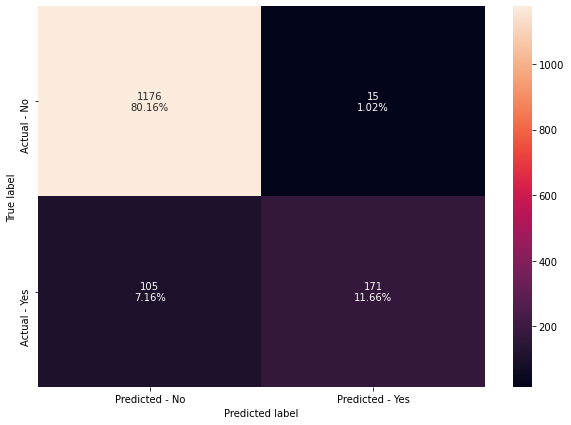

In [66]:
make_confusion_matrix(bagging_estimator_tuned,y_test)

**Observation**

1. We can see that train and test recall for the bagging classifier have increased slightly after hyperparameter tuning 
2. The model is overfitting the data, as train accuracy and recall are much higher than the test accuracy and test recall.

**Bagging classifier with logistic regression as the base estimator**

In [67]:
bagging_lr=BaggingClassifier(base_estimator=LogisticRegression(random_state=1),random_state=1)
bagging_lr.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(random_state=1),
                  random_state=1)

In [68]:
bagging_lr_score=get_metrics_score(bagging_lr)

Accuracy on training set :  0.8380590470622625
Accuracy on test set :  0.8323108384458078
Recall on training set :  0.18788819875776397
Recall on test set :  0.17028985507246377
Precision on training set :  0.7960526315789473
Precision on test set :  0.734375


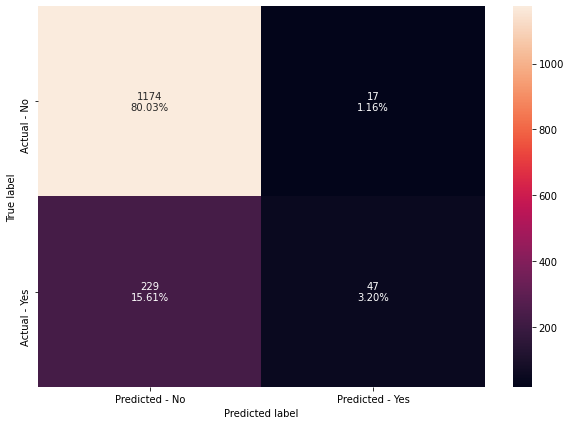

In [69]:
make_confusion_matrix(bagging_lr,y_test)

**Observation**
1. Bagging classifier with logistic regression as base_estimator is not overfitting the data but the test recall is very low.

**Hyperparameter tuning for random forest classifier**

In [70]:
rf_estimator_tuned = RandomForestClassifier(random_state=1)

parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

rf_estimator_tuned = grid_obj.best_estimator_

rf_estimator_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  2.8min finished


RandomForestClassifier(max_features=0.6000000000000001, min_samples_leaf=5,
                       n_estimators=200, random_state=1)

In [71]:
rf_estimator_tuned_score=get_metrics_score(rf_estimator_tuned)

Accuracy on training set :  0.9397836889798304
Accuracy on test set :  0.8807089297886844
Recall on training set :  0.7018633540372671
Recall on test set :  0.44565217391304346
Precision on training set :  0.9699570815450643
Precision on test set :  0.8482758620689655


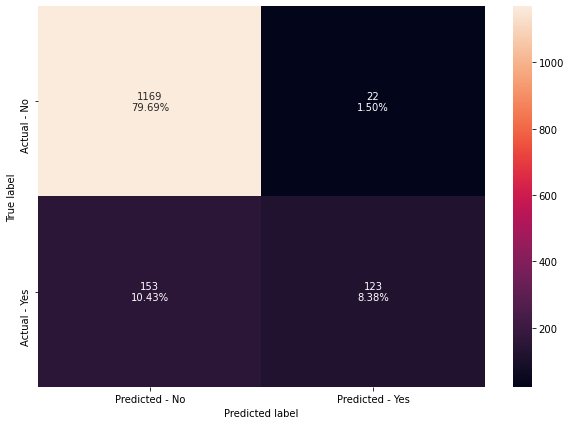

In [72]:
make_confusion_matrix(rf_estimator_tuned,y_test)

**Observation**
1. Random forest's performance has increased as compared to the random forest model with default parameters.
2. The test recall is still very low.

**class_weights for random forest**

In [73]:
rf_estimator_weighted = RandomForestClassifier(random_state=1)

parameters = {
    "class_weight": [{0: 0.3, 1: 0.7}],
    "n_estimators": [100,150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
}

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(rf_estimator_weighted, parameters, scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

rf_estimator_weighted = grid_obj.best_estimator_

rf_estimator_weighted.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


RandomForestClassifier(class_weight={0: 0.3, 1: 0.7},
                       max_features=0.6000000000000001, min_samples_leaf=5,
                       random_state=1)

In [74]:
rf_estimator_weighted_score=get_metrics_score(rf_estimator_weighted)

Accuracy on training set :  0.9725226541946799
Accuracy on test set :  0.8984321745057942
Recall on training set :  0.922360248447205
Recall on test set :  0.6268115942028986
Precision on training set :  0.9310344827586207
Precision on test set :  0.7899543378995434


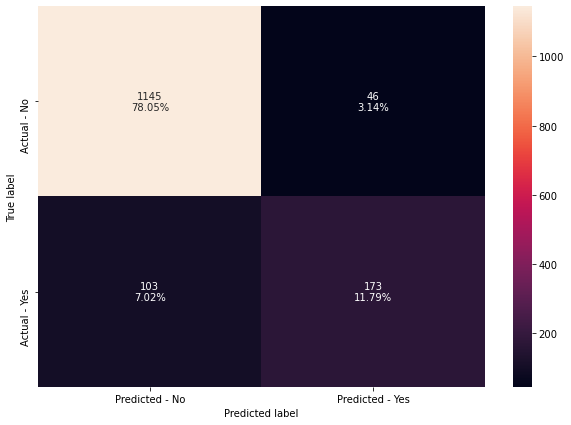

In [75]:
make_confusion_matrix(rf_estimator_weighted,y_test)

**Observation**

1. The model accuracy has decreased a bit but the overfitting has also been reduced.
2. The test recall both have increased slightly.

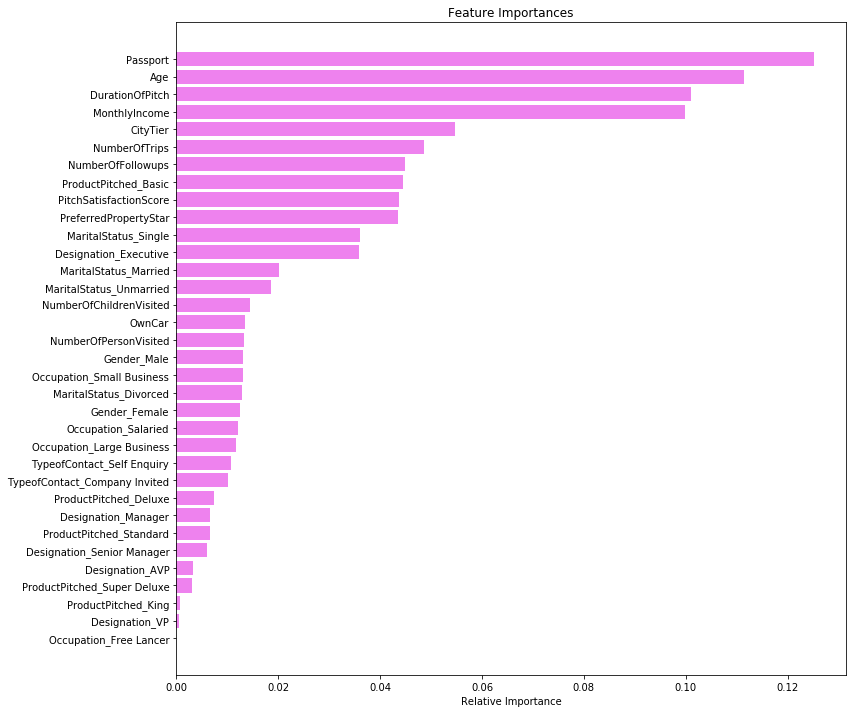

In [82]:
print_feature_importance(rf_estimator_weighted)

# Model building - Boosting

**AdaBoost Classifier**

In [76]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [77]:
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8450745396083017
Accuracy on test set :  0.8520790729379687
Recall on training set :  0.3105590062111801
Recall on test set :  0.3188405797101449
Precision on training set :  0.6993006993006993
Precision on test set :  0.7521367521367521


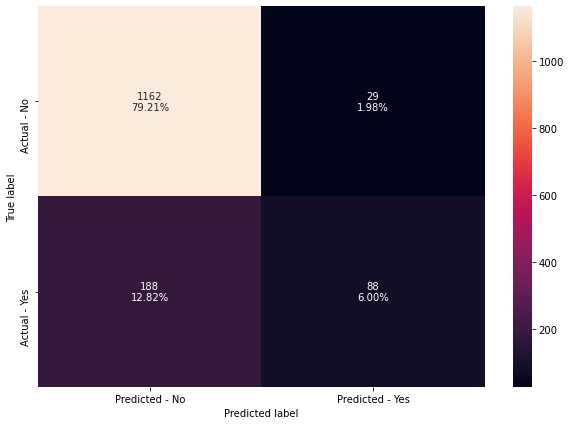

In [78]:
make_confusion_matrix(abc,y_test)

**Observation**
1. Accuracy on test is higher than on train.
2. The recall is pretty low in this model.

**Gradient Boosting Classifier**

In [79]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [80]:
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.8827828120432623
Accuracy on test set :  0.8657123381049762
Recall on training set :  0.44254658385093165
Recall on test set :  0.38768115942028986
Precision on training set :  0.8715596330275229
Precision on test set :  0.7925925925925926


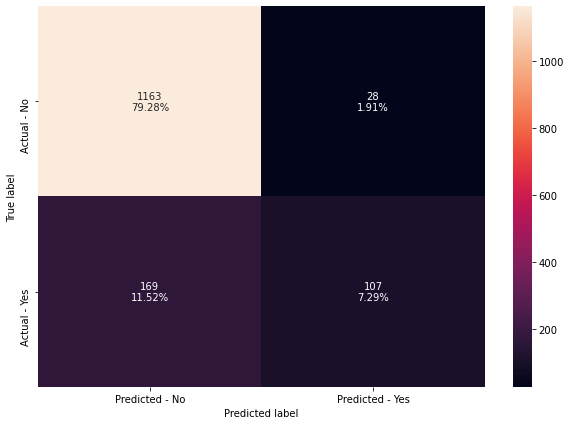

In [81]:
make_confusion_matrix(gbc,y_test)

**Observation**
1. Accuracy of this model has slightly increaded compared to previous model
2. Recall is improved as well.

**XGBoost Classifier**

In [82]:
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train,y_train)

[01:14:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  0.9994153756211634
Accuracy on test set :  0.9195637355146558
Recall on training set :  0.9968944099378882
Recall on test set :  0.6920289855072463
Precision on training set :  1.0
Precision on test set :  0.8526785714285714


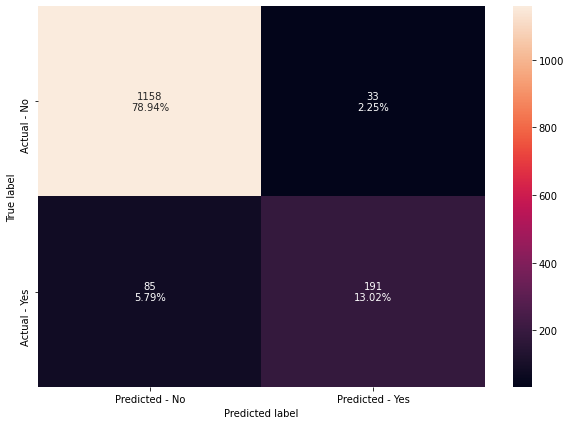

In [84]:
make_confusion_matrix(xgb,y_test)

**Observation**
1. This model overfits the train data.
2. Recall is improved significantly though.

**Hyperparameter tuning for AdaBoost Classifier**

In [85]:
abc_tuned = AdaBoostClassifier(random_state=1)

parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}


acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

abc_tuned = grid_obj.best_estimator_

abc_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 570 candidates, totalling 2850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2850 out of 2850 | elapsed:  7.3min finished


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=1.2000000000000002, n_estimators=100,
                   random_state=1)

In [86]:
abc_tuned_score=get_metrics_score(abc_tuned)

Accuracy on training set :  0.9938614440222158
Accuracy on test set :  0.8732106339468303
Recall on training set :  0.9720496894409938
Recall on test set :  0.6123188405797102
Precision on training set :  0.9952305246422893
Precision on test set :  0.6814516129032258


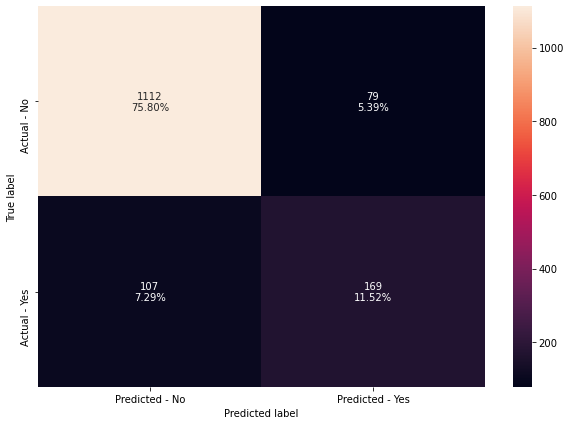

In [87]:
make_confusion_matrix(abc_tuned,y_test)

**Observation**
1. Model is slightly overfitting the train data.
2. Recall is increaded copare to  XG boostnormal ada boost classifier model.

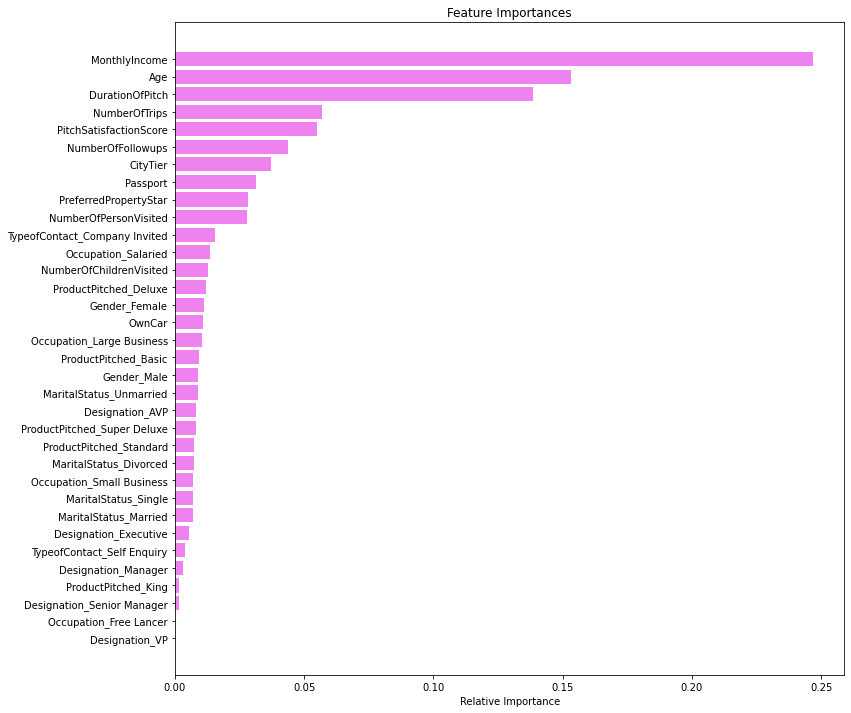

In [88]:
print_feature_importance(abc_tuned)

**Gradient Boosting Classifier using AdaBoost classifier as the estimator for initial predictions**

In [89]:
class AdaBoostClassifier_compability(AdaBoostClassifier):
        def predict(self, X):
            return self.predict_proba(X)[:, 1][:,np.newaxis]
base_estimator = AdaBoostClassifier_compability()
gbc_init = GradientBoostingClassifier(init=base_estimator,random_state=1)
gbc_init.fit(X_train,y_train)

GradientBoostingClassifier(init=AdaBoostClassifier_compability(),
                           random_state=1)

In [90]:
gbc_init_score=get_metrics_score(gbc_init)

Accuracy on training set :  0.8848289973691903
Accuracy on test set :  0.8698023176550784
Recall on training set :  0.44875776397515527
Recall on test set :  0.40217391304347827
Precision on training set :  0.8810975609756098
Precision on test set :  0.8102189781021898


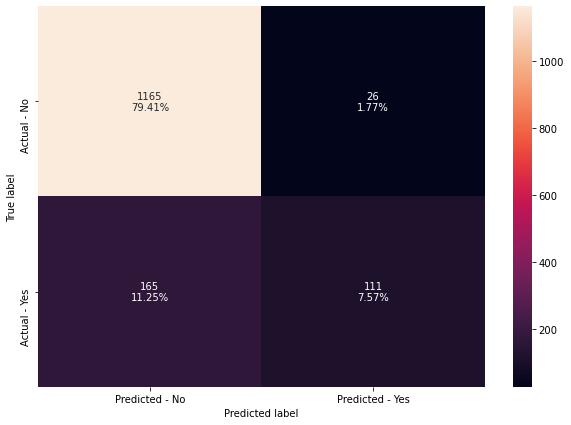

In [91]:
make_confusion_matrix(gbc_init,y_test)

**XG Boost Classifier**

In [127]:
xgb_tuned = XGBClassifier(random_state=1)

parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1],
    'verbosity': [0]
}


acc_scorer = metrics.make_scorer(metrics.recall_score)


grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5,n_jobs = -1, verbose = 2)
grid_obj = grid_obj.fit(X_train, y_train)

xgb_tuned = grid_obj.best_estimator_

xgb_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 15360 candidates, totalling 76800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3738 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 5541 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 6572 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 7789 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 8998 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 10173 tasks      |

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=4, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [37]:
xgb_tuned_score=get_metrics_score(xgb_tuned)

Accuracy on training set :  0.952353113125
Accuracy on test set :  0.896387184731
Recall on training set :  0.981366459627
Recall on test set :  0.847826086957
Precision on training set :  0.807151979566
Precision on test set :  0.68023255814


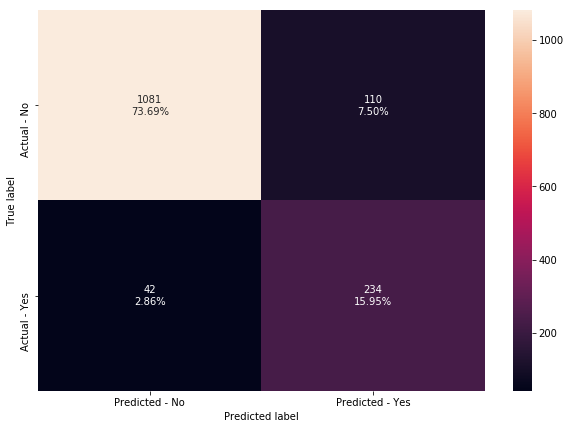

In [38]:
make_confusion_matrix(xgb_tuned,y_test)

**Observation**
1. The Accuracy decreased little bit compared to default parameter, but recall has significantly increased.
2. Decreasing number of false negatives has increased the number of false positives here.
3. The tuned model is not overfitting and generalizes well.

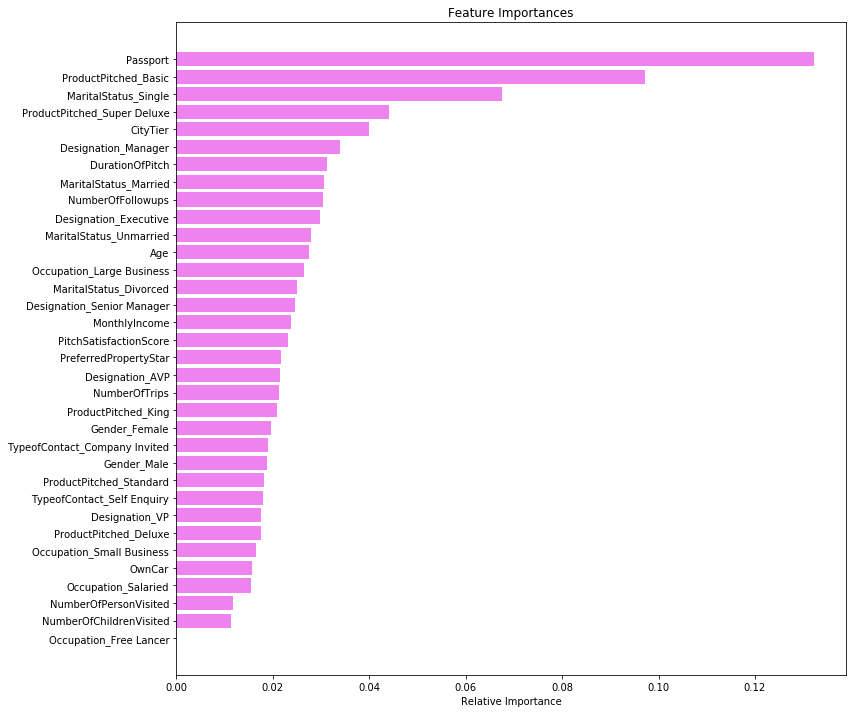

In [42]:
print_feature_importance(xgb_tuned)

# Stacking Classifier

In [119]:
estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42)))
]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())

In [120]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.9086571233810498

In [122]:
clf_score=get_metrics_score(clf)

Accuracy on training set :  0.997076878105817
Accuracy on test set :  0.9086571233810498
Recall on training set :  0.9906832298136646
Recall on test set :  0.6413043478260869
Precision on training set :  0.9937694704049844
Precision on test set :  0.8349056603773585


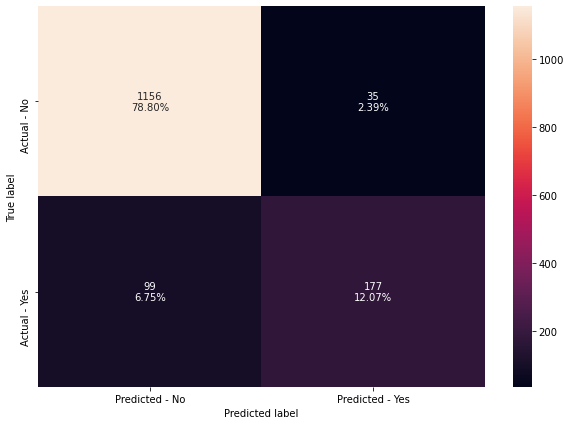

In [126]:
make_confusion_matrix(clf,y_test)

# Comparing all models

In [128]:
# defining list of models
models = [bagging_estimator,bagging_estimator_tuned,bagging_lr,rf_estimator,rf_estimator_tuned,
          rf_estimator_weighted,dTree,dTree1,dTree_estimator, abc, abc_tuned, gbc, gbc_init, xgb, xgb_tuned, clf]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [129]:
comparison_frame = pd.DataFrame({'Model':['Bagging classifier with default base estimator','Bagging classifier with hypertuned parameter',
                                          'Bagging classifier with logistic regression as the base estimator', 
                                          'Random Forest Classifier with default base estimator','Random Forest Classifier with hypertuned parameter',
                                          'Random Forest Classifier with class weight','Decision Tree Model','Decision Tree Model with reduced overfitting',
                                          'Decision Tree Model with Hypertuned Parameter','AdaBoost with default paramters','AdaBoost Tuned', 
                                          'Gradient Boosting with default parameters','Gradient Boosting with init=AdaBoost',
                                          'XGBoost with default parameters','XGBoost Tuned','Stacking Classifier'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Bagging classifier with default base estimator,0.99,0.91,0.97,0.59,1.00,0.87
1,Bagging classifier with hypertuned parameter,1.00,0.92,1.00,0.62,1.00,0.92
2,Bagging classifier with logistic regression as...,0.84,0.83,0.19,0.17,0.80,0.73
3,Random Forest Classifier with default base est...,1.00,0.91,1.00,0.57,1.00,0.94
4,Random Forest Classifier with hypertuned param...,0.94,0.88,0.70,0.45,0.97,0.85
5,Random Forest Classifier with class weight,0.97,0.90,0.92,0.63,0.93,0.79
6,Decision Tree Model,1.00,0.89,1.00,0.67,1.00,0.72
7,Decision Tree Model with reduced overfitting,0.85,0.85,0.45,0.44,0.64,0.66
8,Decision Tree Model with Hypertuned Parameter,0.82,0.84,0.34,0.37,0.54,0.63
9,AdaBoost with default paramters,0.85,0.85,0.31,0.32,0.70,0.75


## Business Insight and Recommendation:

1. Confusion matrix means :
 * True Positive (observed=1,predicted=1): Predicted that package will be taken and the customer took it 
 * False Positive (observed=0,predicted=1): Predicted that package will be taken and the customer did not take it 
 * True Negative (observed=0,predicted=0): Predicted that package will not be taken and the customer did not take it 
 * False Negative (observed=1,predicted=0): Predicted that package will not be taken and the customer took it
 
2. Important Metric:  Here more focus should be towards recall because if the model predicted that package will not be taken for a cusotmer who took the package, then it will result in missed opportunity. Hence the focus should be on increasing Recall. HIghest recall is for the model XGBoost with hypertuned parameter.

3. For XGboost tuned model the features "Passport", "productpitched_basic", "MaritalStatus_Single", "productpitched_delux", 'city tier' seems to be top 5 features which influence the model's output. Company can choose to target those specific customers to maximize the sales of the package.

4. After achieving the desired accuracy we can deploy the model for practical use. The company now can predict who will say yes for the wellness package. They can use the model for upcoming customers.